In [1]:
import pymonntorch as PMT
import torch

In [2]:
import conex as CNX

from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    LIF,
    SpikeTrace,
    NeuronAxon,
    Fire,
    KWTA,
    ActivityBaseHomeostasis,
    VoltageBaseHomeostasis
)

from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    SimpleDendriticInput,
    SimpleSTDP,
    WeightNormalization,
    WeightClip,
)

In [3]:
from plot2_A import Plot
from encoding import PoissonDistribution, ResetMemory
from populationactivity import PopulationActivity
from lateral_inhibition import LateralDendriticInput
from dataGenerator import input_data_generator
import Result

In [4]:
def NeuronNetwork(input_data, input_size=0, output_size = 0, input_time = 40, rest_time = 10,    j_0=20,
    AP=0.01,
    AM=0.005,
    tau_src=3,
    tau_dst=2,
    iteration_number=3000,
    plot_scale=0,
    j_0_lateral=5,
    L4_EXC_R = 5.0,
    L4_EXC_THRESHOLD = 15,
    L4_EXC_TAU = 5.0,
    L4_EXC_V_RESET = 0,
    L4_EXC_V_REST = 5,
    output_prioritize_behaviors=[
        # KWTA(k=1),
        # ActivityBaseHomeostasis(activity_rate=3, window_size=10,updating_rate=0.2, decay_rate=0.2 ),
        
    ],
    output_behaviors={
    },
    synapse_behaviors={},
    synapse_prioritize_behaviors=[
         WeightNormalization()
    ], ):
    net = CNX.Neocortex(dt=1)

    pop1 = PMT.NeuronGroup(net=net,
                        size=input_size or input_data.shape[1],
                        behavior={**CNX.prioritize_behaviors(
                                [
                                    SimpleDendriteStructure(),
                                    SimpleDendriteComputation(),
                                    LIF(
                                        R=L4_EXC_R,
                                        threshold=L4_EXC_THRESHOLD,
                                        tau=L4_EXC_TAU,
                                        v_reset=L4_EXC_V_RESET,
                                        v_rest=L4_EXC_V_REST,
                                    ),
                                    SpikeTrace(tau_s=tau_src),
                                    Fire(),
                                    NeuronAxon(),
                                ]
                        ), 
                        **{
                        10: ResetMemory(),
                        345: PoissonDistribution(time = input_time, data=input_data, rest_time=rest_time, epsilon=0),
                        350: PopulationActivity(),
                        460: PMT.Recorder(variables=["v", "I", "T"],tag="in_recorder"),
                        461: PMT.EventRecorder("spikes", tag="in_ev_recorder"),
                        }
                        })
    
    
    pop2 = PMT.NeuronGroup(net=net,
                        size=output_size or input_data.shape[0],
                        behavior={**CNX.prioritize_behaviors(
                                [
                                    SimpleDendriteStructure(),
                                    SimpleDendriteComputation(),
                                    LIF(
                                        R=L4_EXC_R,
                                        threshold=L4_EXC_THRESHOLD,
                                        tau=L4_EXC_TAU,
                                        v_reset=L4_EXC_V_RESET,
                                        v_rest=L4_EXC_V_REST,
                                    ),
                                    SpikeTrace(tau_s=tau_dst),
                                    Fire(),
                                    NeuronAxon(),
                                    *output_prioritize_behaviors,
                                ],
                        ),
                        **{
                        350: PopulationActivity(),
                        351:Result.Result(print_details = False),
                        460: PMT.Recorder(variables=["v", "I", "T"],tag="in_recorder"),
                        461: PMT.EventRecorder("spikes", tag="in_ev_recorder"),
                        },
                        **output_behaviors,

                        },)

    syn_pop1_pop2 = PMT.SynapseGroup(
        net=net,
        src=pop1,
        dst=pop2,
        tag="Proximal",
        behavior={**CNX.prioritize_behaviors(
                    [
                        SynapseInit(),
                        WeightInitializer(mode="random"),
                        SimpleDendriticInput(current_coef=j_0),
                        SimpleSTDP(a_plus=AP, 
                                    a_minus=AM,
                                    positive_bound="soft_bound",
                                    negative_bound="soft_bound",
                                    ),
                        *synapse_prioritize_behaviors
                    ]
                ),
                **{
                    460: PMT.Recorder(variables=["weights"], tag="sg_inp_out")
                        },
                **synapse_behaviors},
    )
    
    synapse_lateral = PMT.SynapseGroup(
        net=net,
        src=pop2,
        dst=pop2,
        tag="Proximal",
        behavior=CNX.prioritize_behaviors(
                    [
                        SynapseInit(),
                        WeightInitializer(mode="random"),
                        LateralDendriticInput(current_coef=j_0_lateral),
                    ]
                    )
        )
    

    net.initialize(info=False)
    net.simulate_iterations(iteration_number )
    
    print ("---------------result----------------")
    for i in range (len(pop2.result)):
        temp = ', '.join(map(str,map(int,pop2.result[i][0]))) if pop2.result[i][0].shape[0] != pop2.size else "None"
        print (f"{i} -> {temp}")
        
    print ("-------------parameters---------------")
    
    for p in [
                "j_0={:.2f}".format(j_0),
                "iteration={:.2f}".format(iteration_number),
                "j_0_lateral={:.2f}".format(j_0_lateral),
                "input_size={:.2f}".format(input_size or input_data.shape[1]),
                "output_size={:.2f}".format(output_size or input_data.shape[0]),
                *output_prioritize_behaviors,
                *synapse_prioritize_behaviors

        ]:
        print (p)
    
    
    print ("-------------------------------------")
    Plot(
        net=net,
        ngs=[pop1, pop2],
        scaling_factor=5,
        sgs=[syn_pop1_pop2],
        label_font_size=6,
        recorder_index=460,
        env_recorder_index=461,
        )

0 16
16 32
32 48
48 64
64 80
80 96


/Users/delaram/Me/university/term 8/NS/homework/HW4/code_project4/encoding.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.parameter("data", required=True))


3000xBatch: 1/1 (100%) 2167.508ms
---------------result----------------
0 -> 3
1 -> 3
2 -> 2
3 -> 0
4 -> 4
5 -> 1
-------------parameters---------------
j_0=30.00
iteration=3000.00
j_0_lateral=10.00
input_size=100.00
output_size=5.00
KWTA(k=1,dimension=None,)
ActivityBaseHomeostasis(activity_rate=40,window_size=300,updating_rate=0.2,decay_rate=0.2,)
WeightNormalization(norm=1,)
-------------------------------------


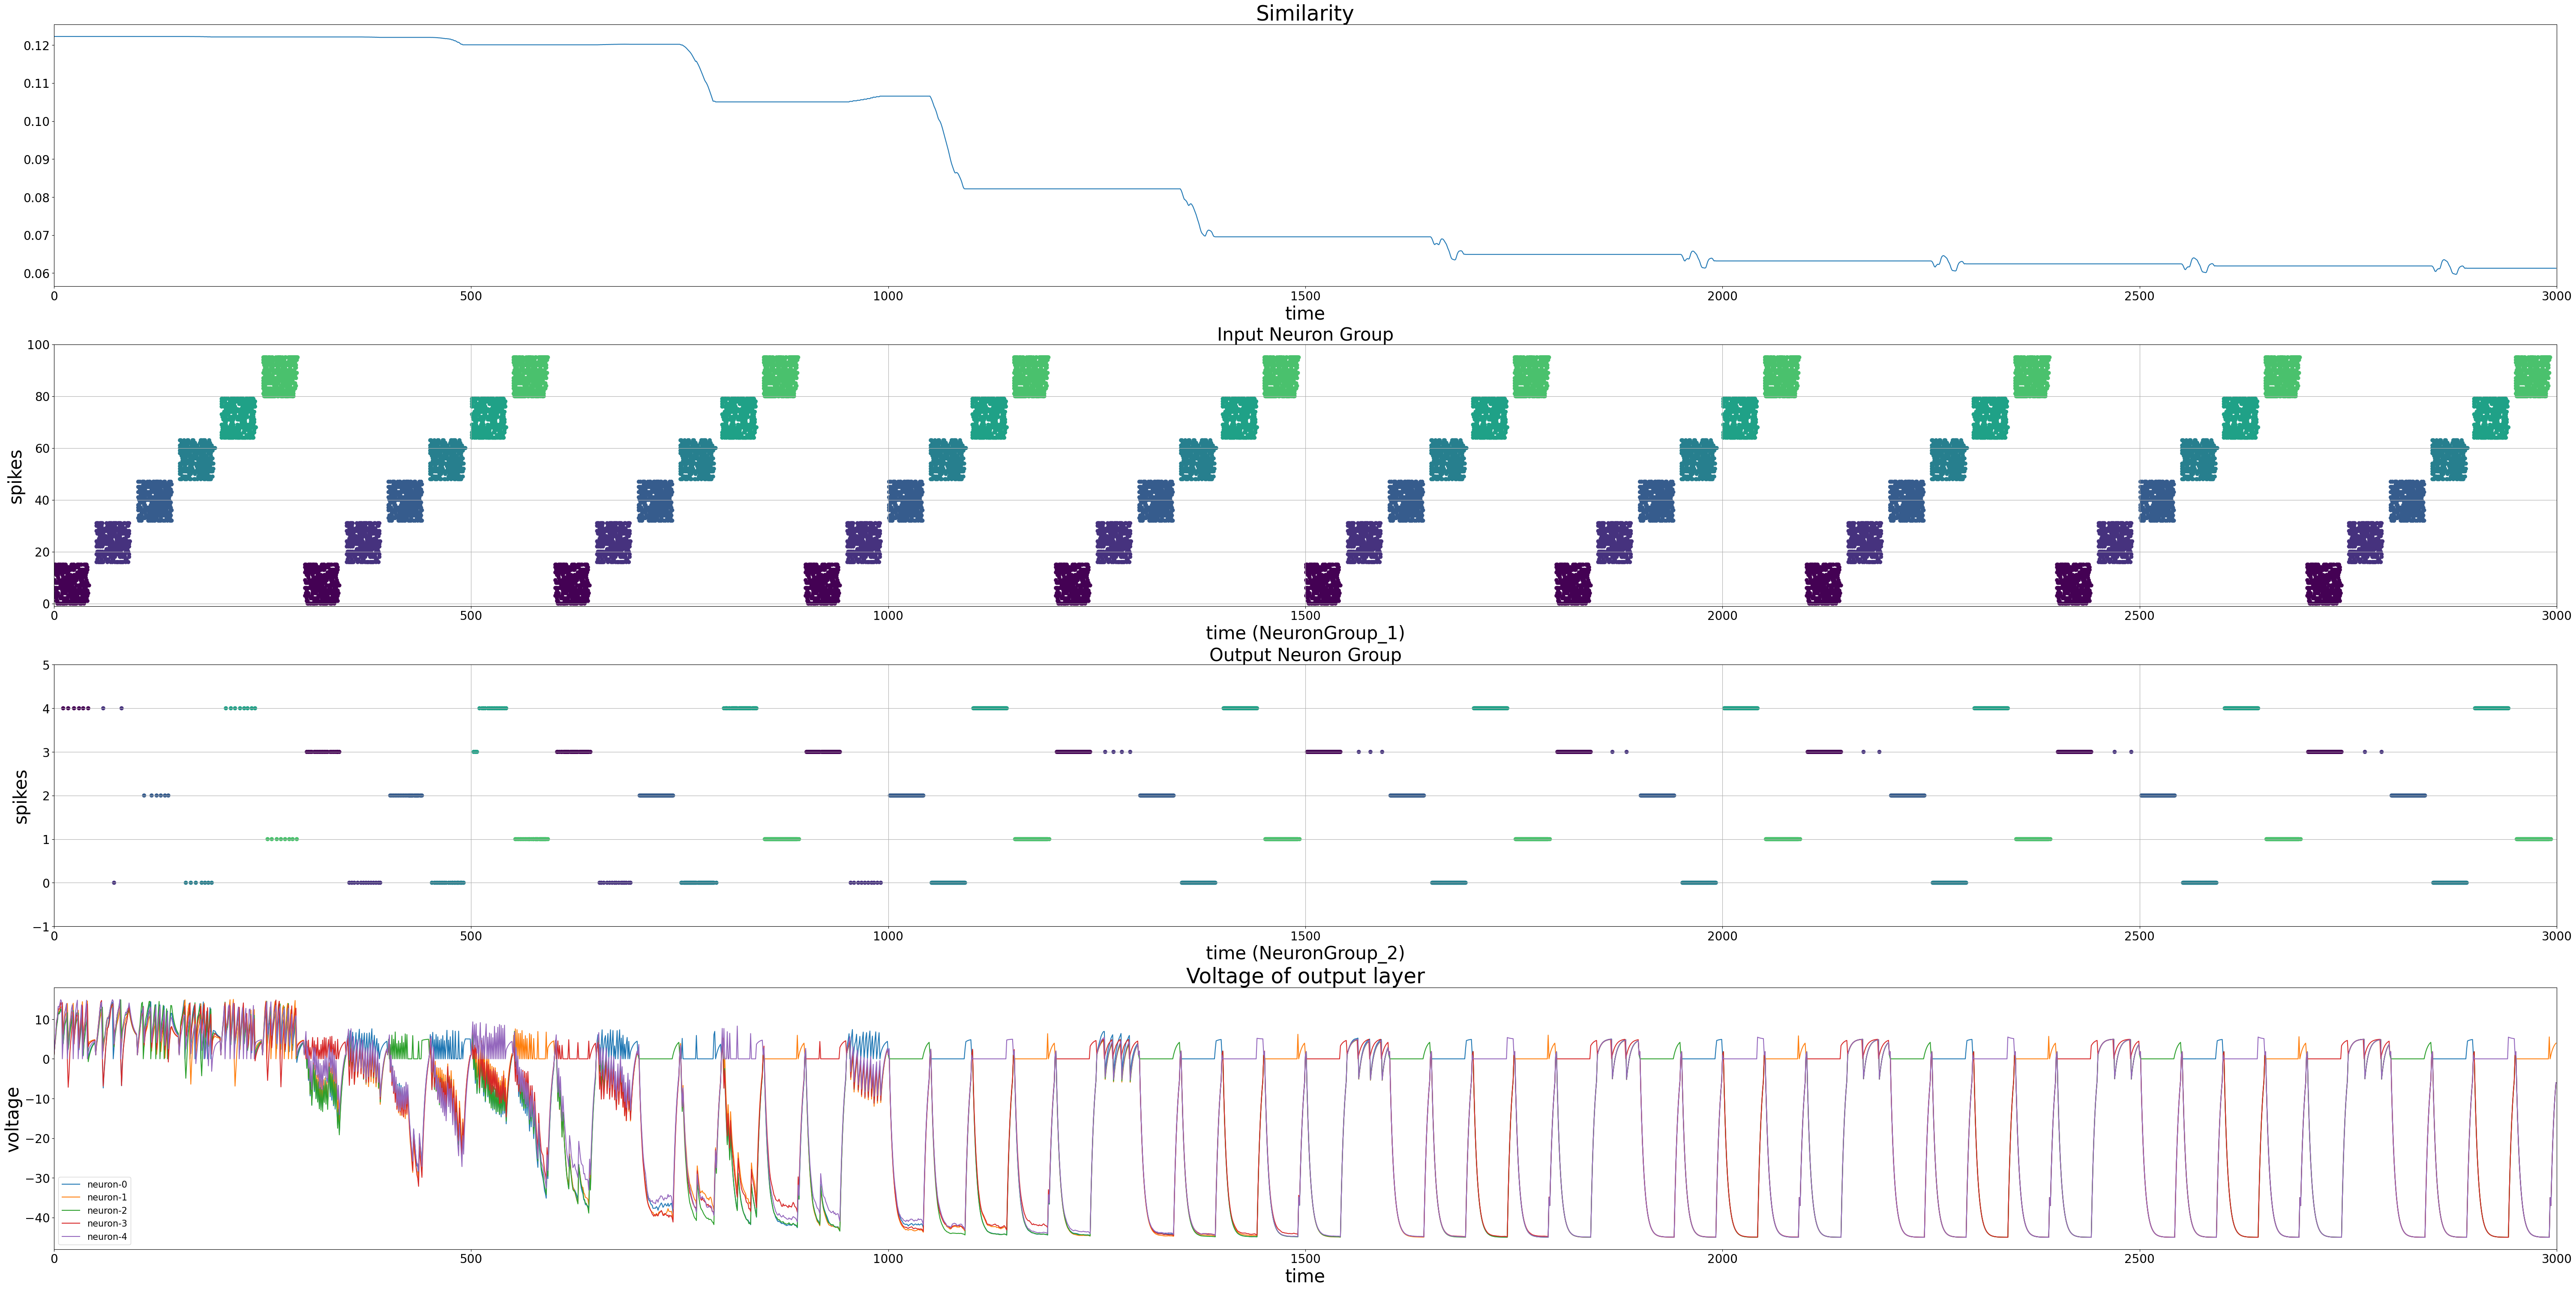

In [5]:
NeuronNetwork(input_data=input_data_generator(size=100,output_size=6,overlap=0.0),
              iteration_number=3000,
              j_0=30,
              j_0_lateral=10,    
              AP=0.05,
              AM=0.025,
              output_prioritize_behaviors=[
                KWTA(k=1),
                ActivityBaseHomeostasis(activity_rate=40, window_size=300,updating_rate=0.2, decay_rate=0.2 ),
                ],
            output_size=5
            )

0 16
16 32
32 48
48 64
64 80
80 96
3000xBatch: 1/1 (100%) 2569.633ms
---------------result----------------
0 -> 4
1 -> 0
2 -> 6
3 -> 7
4 -> 5
5 -> 2
-------------parameters---------------
j_0=30.00
iteration=3000.00
j_0_lateral=10.00
input_size=100.00
output_size=8.00
KWTA(k=8,dimension=None,)
ActivityBaseHomeostasis(activity_rate=40,window_size=300,updating_rate=0.1,decay_rate=0.3,)
WeightNormalization(norm=1,)
-------------------------------------


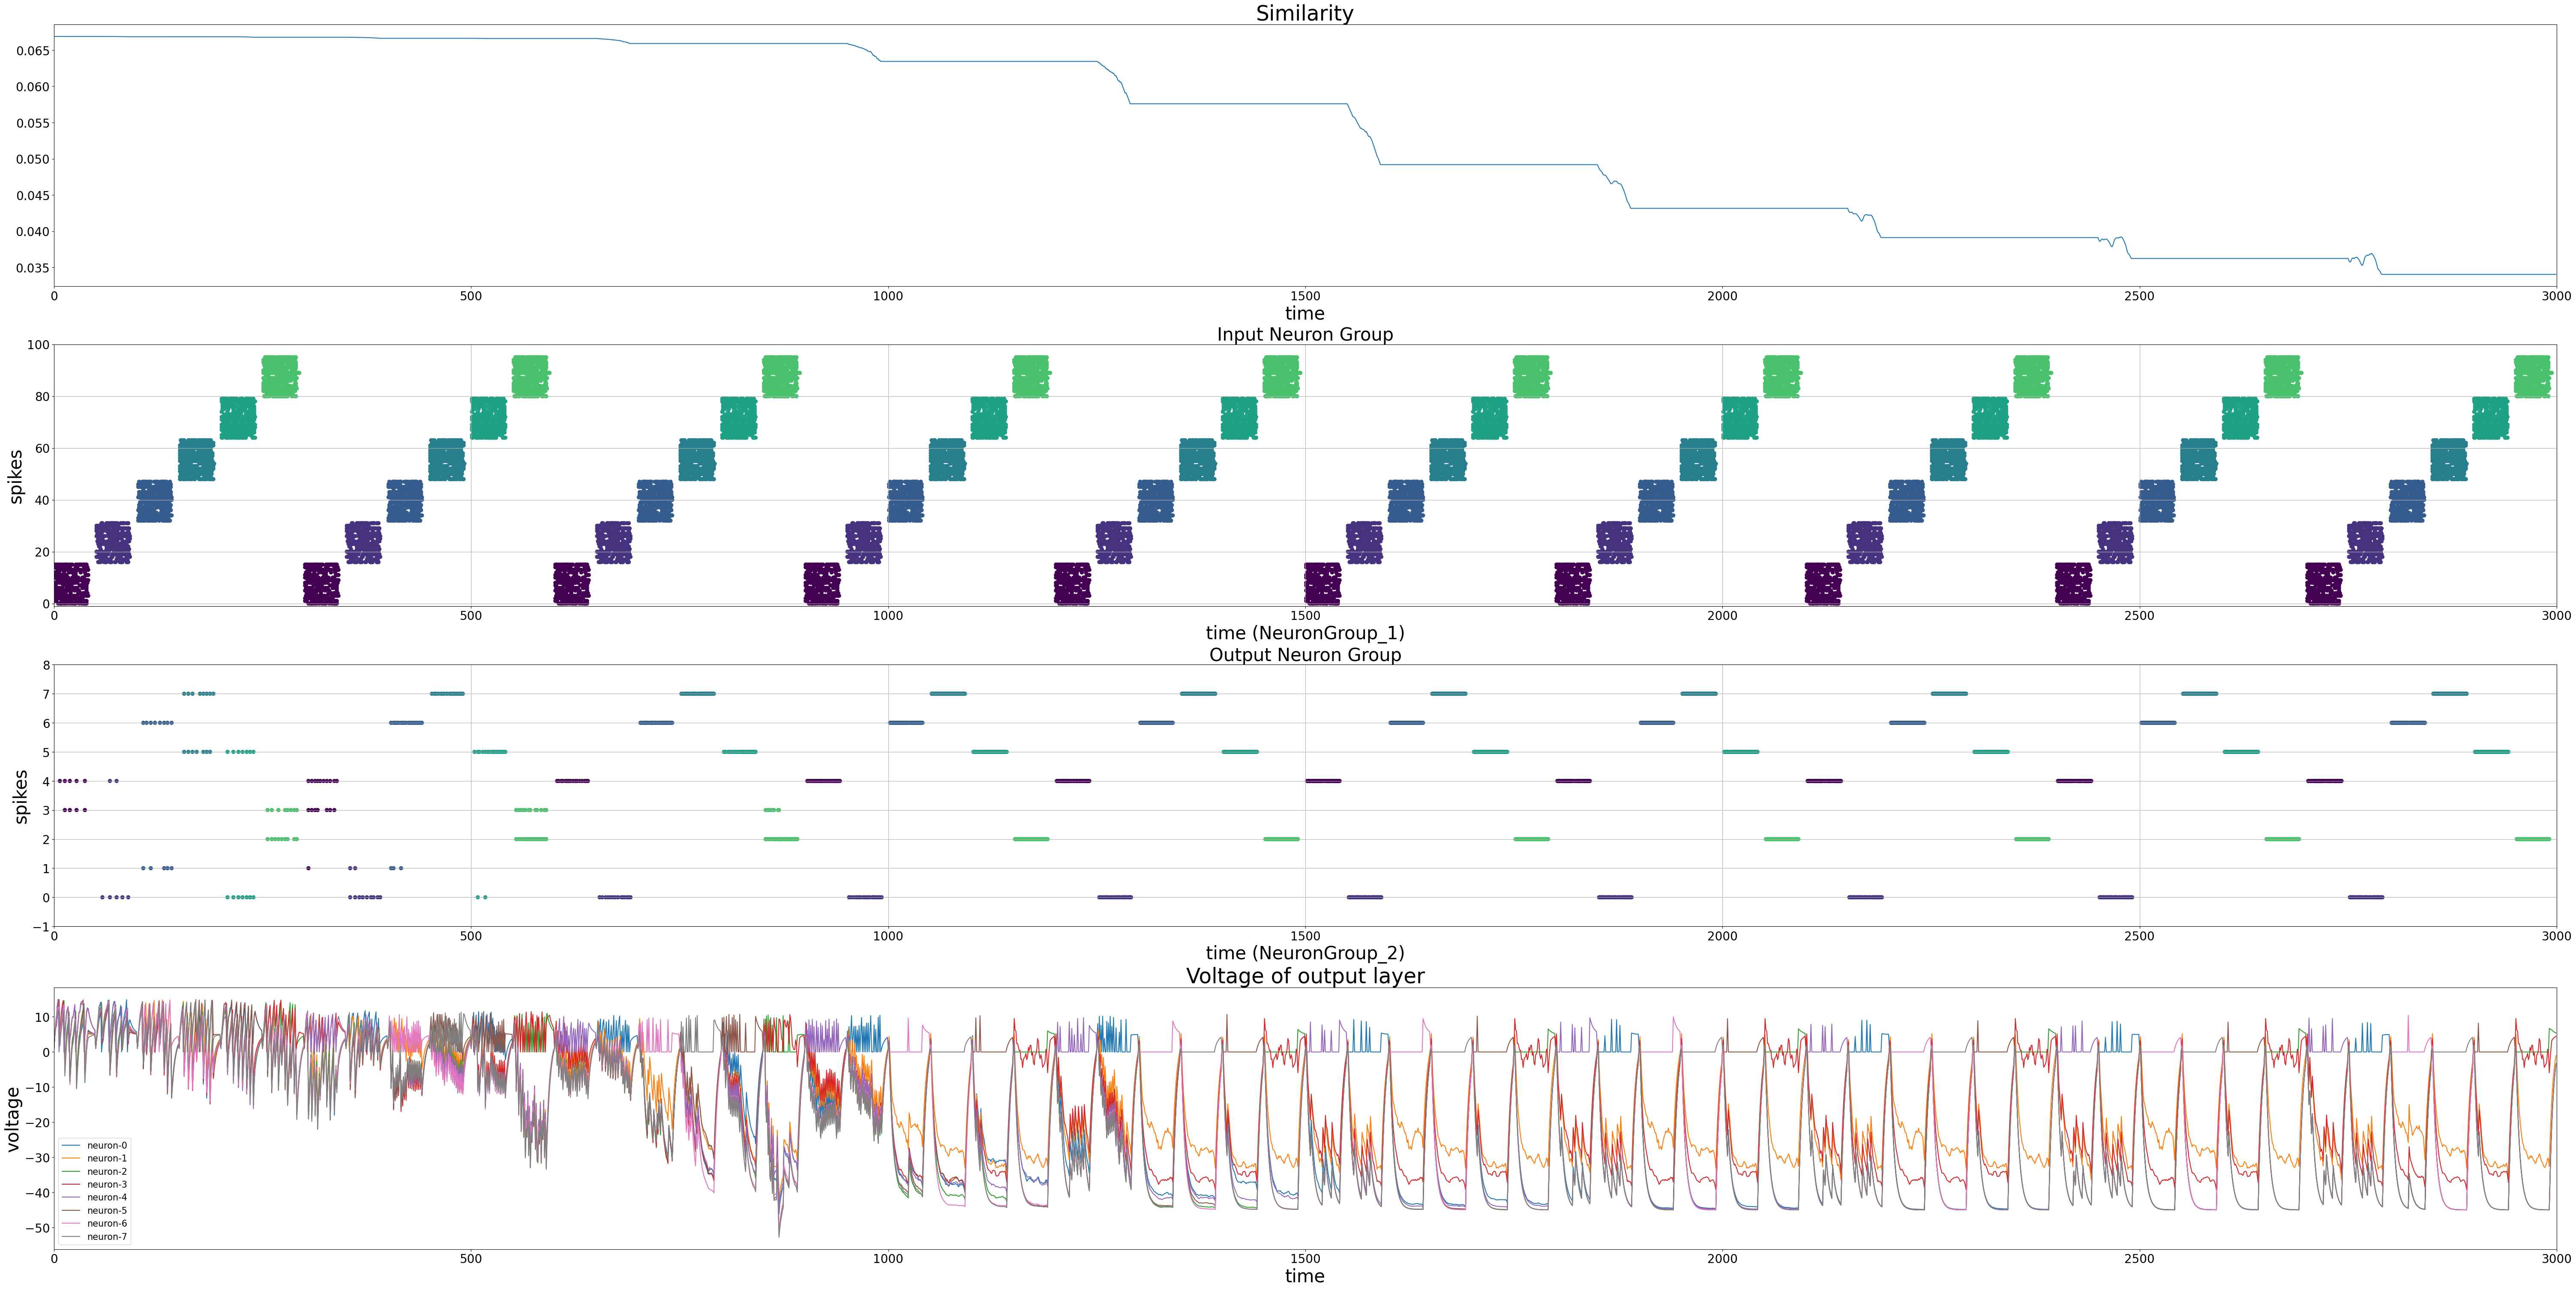

In [6]:
NeuronNetwork(input_data=input_data_generator(size=100,output_size=6,overlap=0.0),
              iteration_number=3000,
              j_0=30,
              j_0_lateral=10,    
              AP=0.05,
              AM=0.025,
              output_prioritize_behaviors=[
                KWTA(k=8),
                ActivityBaseHomeostasis(activity_rate=40, window_size=300,updating_rate=0.1, decay_rate=0.3 ),
                ],
            output_size=8
            )

0 20
20 40
40 60
60 80
80 100
2000xBatch: 1/1 (100%) 1807.073ms
---------------result----------------
0 -> 2
1 -> 0, 7
2 -> 8
3 -> 5
4 -> 1
-------------parameters---------------
j_0=50.00
iteration=2000.00
j_0_lateral=5.00
input_size=100.00
output_size=10.00
KWTA(k=2,dimension=None,)
ActivityBaseHomeostasis(activity_rate=20,window_size=250,updating_rate=0.2,decay_rate=0.5,)
WeightNormalization(norm=1,)
-------------------------------------


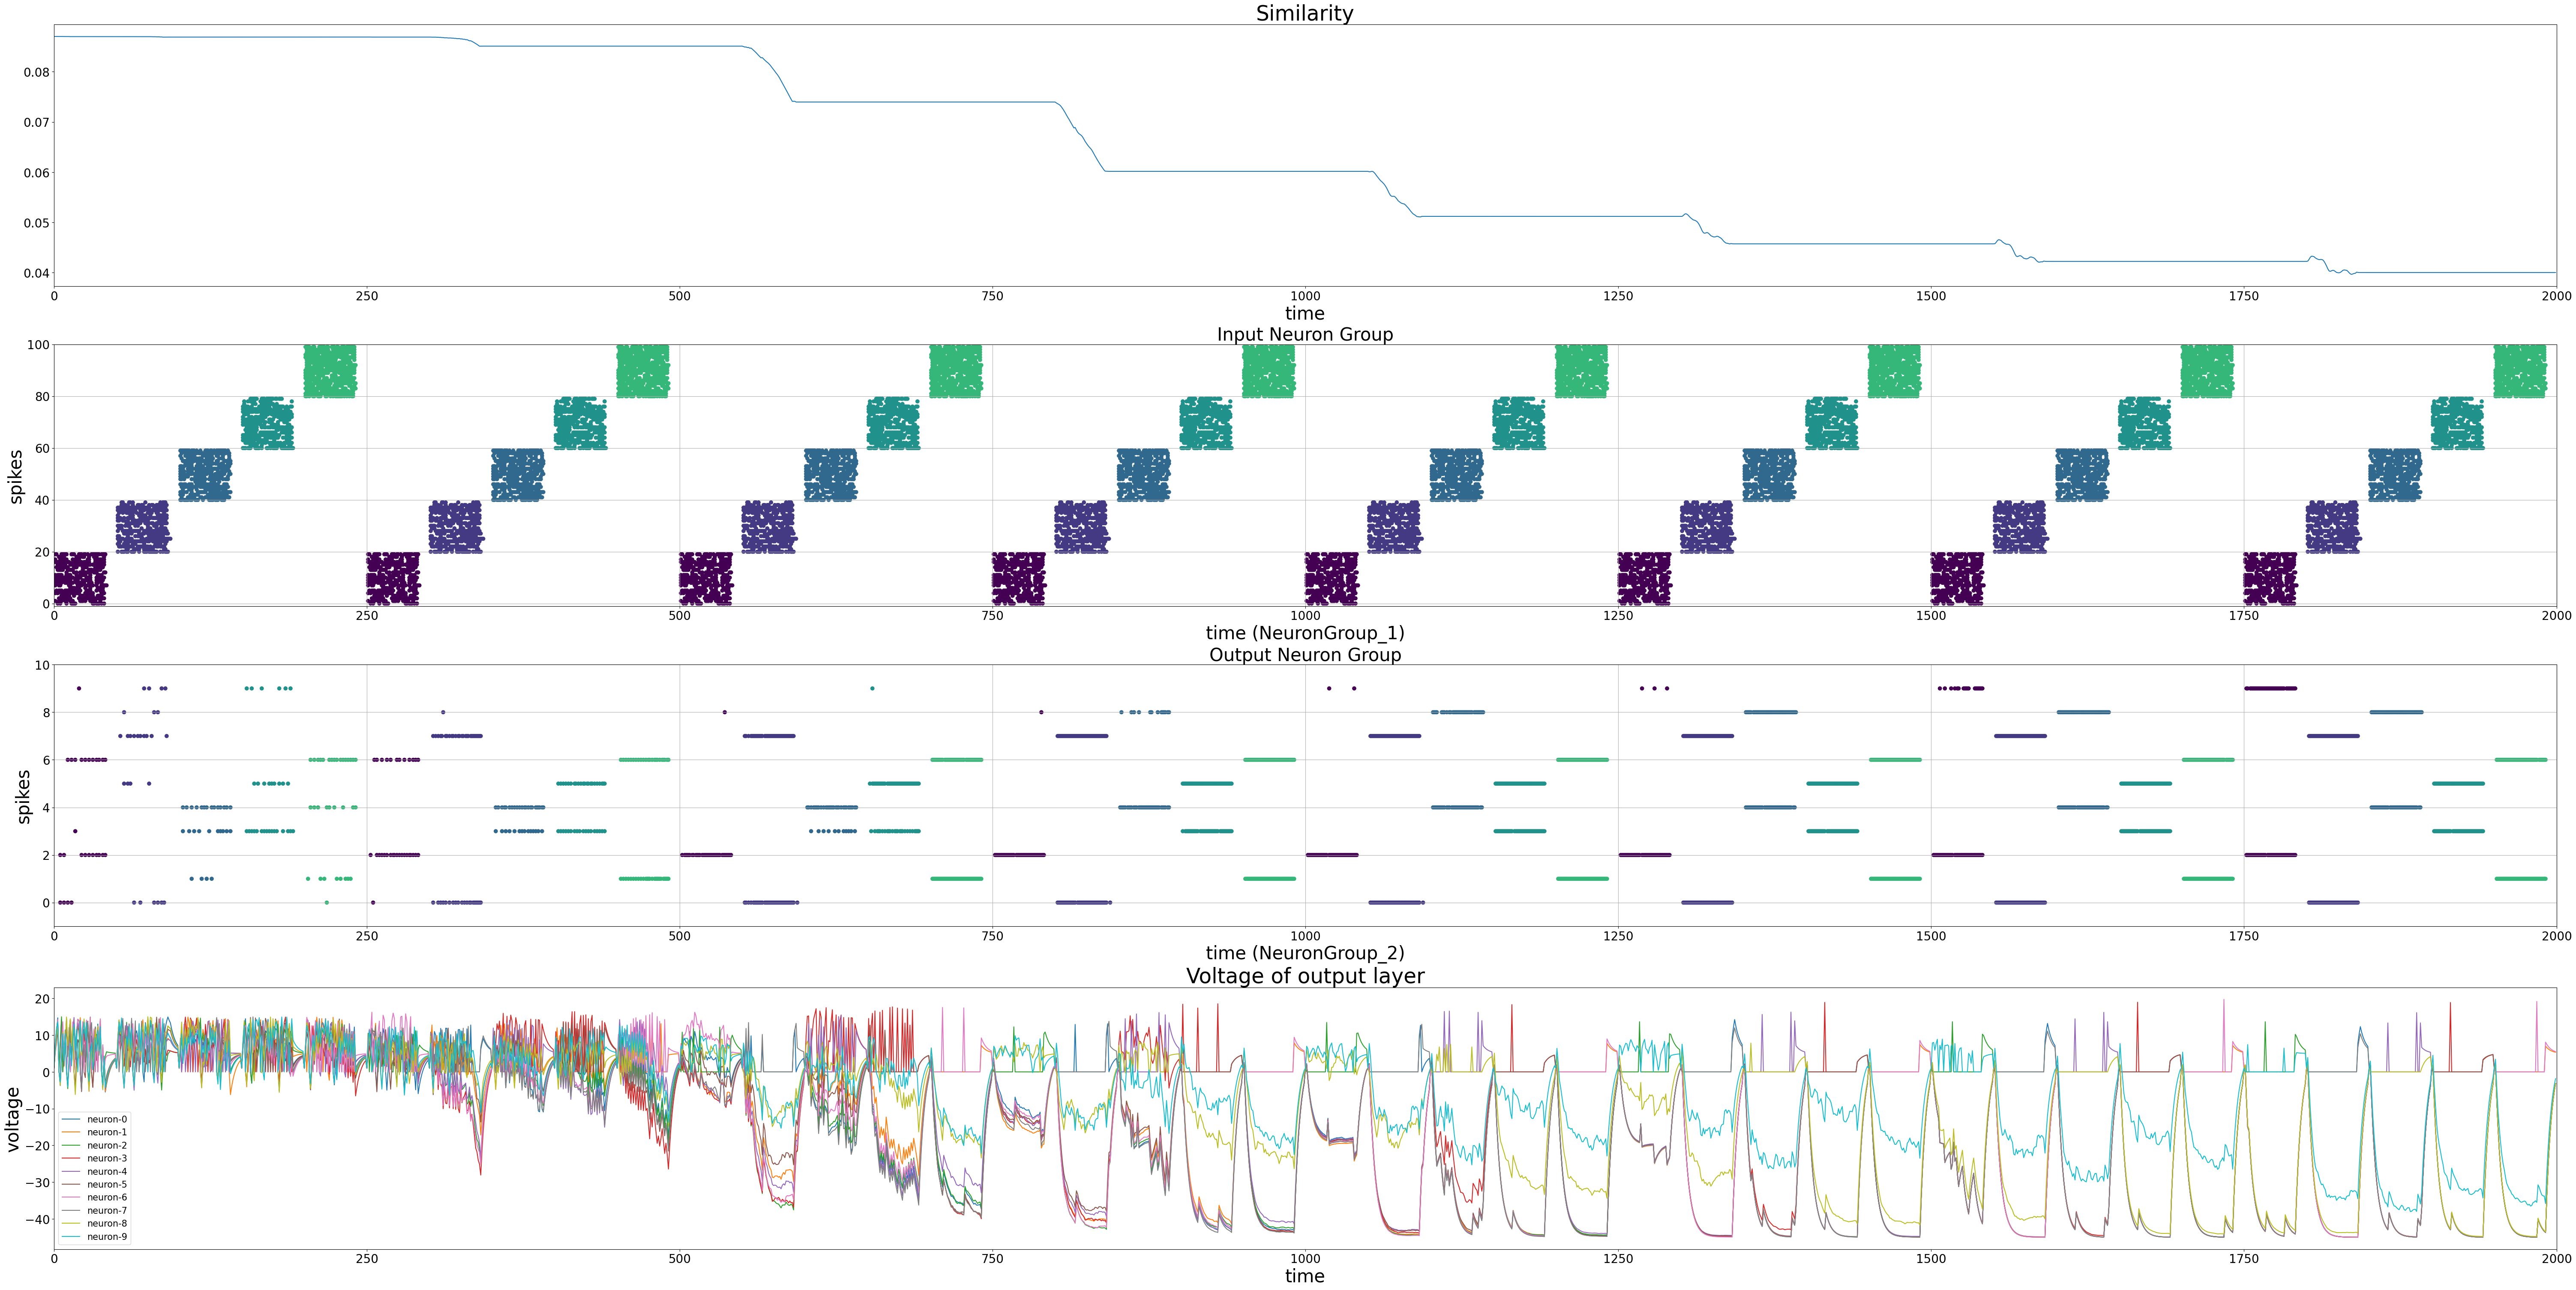

In [13]:
NeuronNetwork(input_data=input_data_generator(size=100,output_size=5,overlap=0.0),
              iteration_number=2000,
              j_0=50,
              j_0_lateral=5,    
              AP=0.05,
              AM=0.025,
              output_prioritize_behaviors=[
                KWTA(k=2),
                ActivityBaseHomeostasis(activity_rate=20, window_size=250,updating_rate=0.2, decay_rate=0.5 ),
                ],
            output_size=10
            )